In [1]:
import re
import string

# !pip install -U nltk

# import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
from nltk.tokenize import sent_tokenize # Sentence Tokenizer
from nltk.tokenize import word_tokenize # Word Tokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.probability import FreqDist

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1) (optional) Scrape 100 Job Listings that contain the title "Data Scientist" from indeed.com

At a minimum your final dataframe of job listings should contain
- Job Title
- Job Description

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

In [3]:
# Based on Edward Barnett's query_generator 
def query_generator(keyword, location, radius=10, age=30):
    '''
    Generates query URLs for Indeed.com. Shows 50 results,
    finds only jobs on employer site,
    sorts by relevance, shows only full-time jobs
    
    Inputs:
    -------
    keyword (string) : keyword for the job title
    location (string) : city or zip code
    radius (int) : Miles from the place noted above
    age : How many days since job was posted

    Outputs:
    --------
    The query url
    '''

    keyword = keyword.replace(' ', '+')
    location = location.replace(' ', '+')
    
    string1 = f"https://www.indeed.com/jobs?as_and={keyword}&as_phr=&as_any=&as_not=&as_ttl=&as_cmp=&jt=fulltime&st=employer"
    string2 = f"sr=directhire&as_src=&salary=&radius={radius}&l={location}&fromage={age}&limit=50&sort=&psf=advsrch"
    query = string1+string2

    return query

test_query = query_generator("data scientist", "San Francisco, CA")
print(test_query)

https://www.indeed.com/jobs?as_and=data+scientist&as_phr=&as_any=&as_not=&as_ttl=&as_cmp=&jt=fulltime&st=employersr=directhire&as_src=&salary=&radius=10&l=San+Francisco,+CA&fromage=30&limit=50&sort=&psf=advsrch


In [4]:
url = 'https://www.indeed.com/jobs?q=data+scientist&l=San+Francisco,+CA&radius=15&rbl=San+Francisco,+CA&jlid=6cf5e6d389fd6d6b&jt=fulltime&limit=50&fromage=15'
page = requests.get(url)
soup = BeautifulSoup(page.text, 'html.parser')

In [5]:
soup.find(td="resultsCol") #jobsearch-SerpJobCard

In [6]:
url = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-2-NLP/master/module2-Bag-of-Words/job_listings.csv'
df = pd.read_csv(url, index_col=0)
print(df.shape)
df.head()

(426, 2)


,description,title
0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist
1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I
2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level
3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist
4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist


In [7]:
# What does one entry look like?
df.description[0]

'b"<div><div>Job Requirements:</div><ul><li><p>\\nConceptual understanding in Machine Learning models like Nai\\xc2\\xa8ve Bayes, K-Means, SVM, Apriori, Linear/ Logistic Regression, Neural, Random Forests, Decision Trees, K-NN along with hands-on experience in at least 2 of them</p>\\n</li><li><p>Intermediate to expert level coding skills in Python/R. (Ability to write functions, clean and efficient data manipulation are mandatory for this role)</p>\\n</li><li><p>Exposure to packages like NumPy, SciPy, Pandas, Matplotlib etc in Python or GGPlot2, dplyr, tidyR in R</p>\\n</li><li><p>Ability to communicate Model findings to both Technical and Non-Technical stake holders</p>\\n</li><li><p>Hands on experience in SQL/Hive or similar programming language</p>\\n</li><li><p>Must show past work via GitHub, Kaggle or any other published article</p>\\n</li><li><p>Master\'s degree in Statistics/Mathematics/Computer Science or any other quant specific field.</p></li></ul><div><div><div><div><div><d

## 2) Use NLTK to tokenize / clean the listings 

In [8]:
import string
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize # Sentence Tokenizer
from nltk.tokenize import word_tokenize # Word Tokenizer
from nltk.stem.wordnet import WordNetLemmatizer

# Remove extra quatation marks and a leading b from each string
job_listings = [x[2:-1] for x in df.description.tolist()]

table = str.maketrans(string.punctuation,' '*32)
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
cleaned_listings = []

for listing in job_listings:
    # Remove HTML tags and paragraph breaks (\\n)
    listing = re.sub(pattern=r'\\n|<[\w/]+>', repl='', string=listing)
    
#     print(listing)
    # Strip punctuation everywhere,
    # replacing it with spaces so that words separated only
    # by punctuation don't get smooshed together
    no_punctuation = listing.translate(table)
#     print("No Punctuation:", no_punctuation)
#     print('------------------------------------------')
    
    # Tokenize by word
    tokens = word_tokenize(no_punctuation)
#     print("Tokens:", tokens)
#     print('------------------------------------------')
    
    # Make all words lowercase
    lowercase_tokens = [w.lower() for w in tokens]
#     print("Lowercase:", lowercase_tokens)
#     print('------------------------------------------')
    
    # Remove words that aren't alphabetic
    alphabetic = [w for w in lowercase_tokens if w.isalpha()]
#     print("Alphabetic:", alphabetic)
#     print('------------------------------------------')
    
    # Remove stopwords
    words = [w for w in alphabetic if not w in stop_words]
#     print("Cleaned Words:", words)
#     print("--------------------------------")
    
    # lemmatize!
    lemmas = [lemmatizer.lemmatize(w) for w in words]
    # Append to list
    cleaned_listings.append(words)

In [9]:
# cleaned_listings[0]

# 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

# Get it into form ["word word word", "word word word"]
cleaned_as_strings = [" ".join(x) for x in cleaned_listings]

# Instantiate vectorizer object
vectorizer = CountVectorizer()
# Create a vocabulary and get word counts per document
bag_of_words = vectorizer.fit_transform(cleaned_as_strings)
# Get feature names to use as dataframe column headers
feature_names = vectorizer.get_feature_names()

In [11]:
bow_df = pd.DataFrame(bag_of_words.toarray(), columns=feature_names)
bow_df.head()

,aa,aap,ab,abernathy,abilities,abilitiesability,abilitiesdevelops,abilitiesexperience,abilitiesinterpersonal,abilitiesproblem,...,zenreach,zero,zeus,zf,zheng,zillow,zonesability,zoom,zuckerberg,zurich
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# 4) Visualize the most common word counts

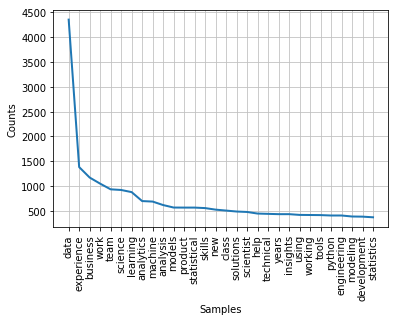

In [12]:
from nltk.probability import FreqDist
from itertools import chain
import matplotlib.pyplot as plt

# Flatten cleaned_listings into a list of words, rather than
# a list of lists of words
all_the_words = list(chain(*cleaned_listings))

fdist = FreqDist(all_the_words)

fdist.plot(30,cumulative=False)
plt.show()

 # 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
pd.options.display.max_columns = 30

# List of document strings as text
text = cleaned_as_strings
# Instantiate vectorizer object
tfidf = TfidfVectorizer(max_features = 30)
# Create a vocabulary and get word counts per document
feature_matrix = tfidf.fit_transform(text)
# Get feature names to use as dataframe column headers
feature_names = tfidf.get_feature_names()

# View Feature Matrix as DataFrame
df = pd.DataFrame(feature_matrix.toarray(), columns=feature_names)
df.head()

,analysis,analytics,business,class,data,development,engineering,experience,help,insights,learning,machine,modeling,models,new,product,python,science,scientist,skills,solutions,statistical,statistics,team,technical,tools,using,work,working,years
0,0.000000,0.000000,0.000000,0.000000,0.164138,0.000000,0.000000,0.363135,0.000000,0.0,0.217297,0.234707,0.000000,0.254200,0.000000,0.000000,0.425145,0.202053,0.000000,0.232938,0.0,0.000000,0.246375,0.000000,0.548134,0.000000,0.0,0.193088,0.000000,0.000000
1,0.085779,0.000000,0.077362,0.000000,0.244215,0.402224,0.000000,0.270147,0.289725,0.0,0.242481,0.261908,0.000000,0.094554,0.188118,0.207882,0.079070,0.150314,0.084713,0.173290,0.0,0.000000,0.000000,0.376688,0.305831,0.093568,0.0,0.215466,0.191618,0.000000
2,0.000000,0.177155,0.432550,0.213782,0.341368,0.000000,0.187412,0.125872,0.000000,0.0,0.150642,0.162711,0.205685,0.352450,0.000000,0.000000,0.147366,0.140074,0.315770,0.322970,0.0,0.168183,0.170800,0.000000,0.000000,0.000000,0.0,0.133859,0.178565,0.000000
3,0.000000,0.000000,0.000000,0.829449,0.220745,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.170039,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.408583,0.000000,0.000000,0.0,0.259678,0.000000,0.000000
4,0.000000,0.399069,0.324795,0.000000,0.512656,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.396974,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.427999,0.000000,0.0,0.000000,0.000000,0.362856


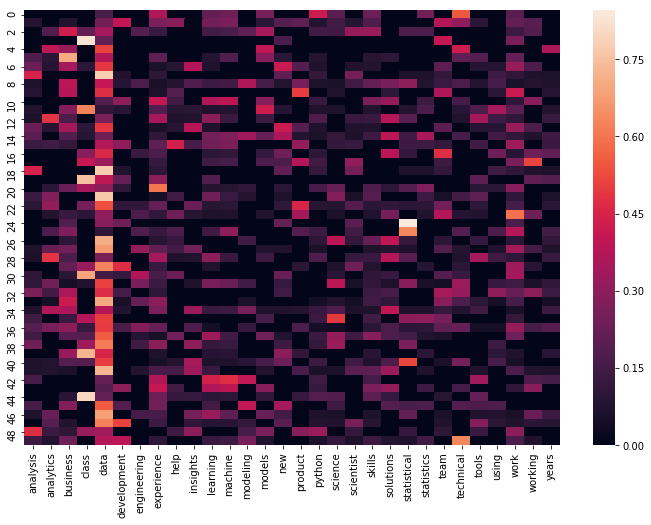

In [14]:
import seaborn as sns
# A heatmap is the best way to see the TF-IDF score of the first 50
# Job listings
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.heatmap(df[:50]);

## Stretch Goals

 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.